# Data Augmentation

### Leemos el dataset

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
import random
#from tqdm.notebook import tqdm
from PIL import Image
from PIL import ImageEnhance
np.random.seed(1) #to have reproducible results 
pd.set_option('display.max_colwidth', None)

In [22]:
glob.glob('.//Dataset/*/*.jpg', recursive=True)[0]

'.//Dataset\\AntMan\\am1.jpg'

In [23]:
paths = glob.glob('.//Dataset/*/*.jpg', recursive=True)
paths[0]

'.//Dataset\\AntMan\\am1.jpg'

In [24]:
orig = np.array([np.asarray(Image.open(img)) for img in paths], dtype='object')
orig[0].shape

(1481,)

In [33]:
test = orig[0:16]
def show_images(imgarr):
    plt.figure(figsize=(20,20))
    i = 0
    sizee = int(imgarr.shape[0]/4)+4
    for img in imgarr:
        plt.subplot(sizee, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        i += 1
    plt.suptitle("Original", fontsize=20)
    plt.show()

#### CV2

In [26]:
import os
import cv2
import numpy as np
import random

def file_lines_to_list(path):
    '''
    ### Convert Lines in TXT File to List ###
    path: path to file
    '''
    with open(path) as f:
        content = f.readlines()
    content = [(x.strip()).split() for x in content]
    return content


def get_file_name(path):
    '''
    ### Get Filename of Filepath ###
    path: path to file
    '''
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

def colorjitter(img, cj_type="b"):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img


def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image


def filters(img, f_type = "blur"):
    '''
    ### Filtering ###
    img: image
    f_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if f_type == "blur":
        image=img.copy()
        fsize = 9
        return cv2.blur(image,(fsize,fsize))
    
    elif f_type == "gaussian":
        image=img.copy()
        fsize = 9
        return cv2.GaussianBlur(image, (fsize, fsize), 0)
    
    elif f_type == "median":
        image=img.copy()
        fsize = 9
        return cv2.medianBlur(image, fsize)

#### Imgaug

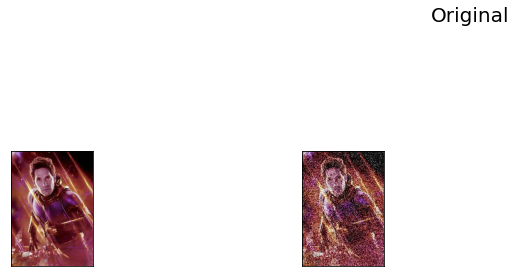

In [31]:
import imgaug as ia
import imgaug.augmenters as iaa

transform = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(20,70))])
sa = cv2.imread(paths[0])
ti = transform(image=sa)
show_images([sa, ti])

#### Resize al dataset:

In [56]:
for img_path in paths:
       img_name = img_path.split('\\')[-1].split('.')[0]
       dir_path = f"ResizedDataset\\"+img_path.split('\\')[-2]
       if not os.path.exists(dir_path):
              os.makedirs(dir_path)
    
       # read image
       img = cv2.imread(img_path)
       height, width, channels = img.shape

       # create new image of desired size and color (blue) for padding
       new_image_height = 400
       new_image_width = 400

       if (width>new_image_width or height>new_image_height):
              #percent by which the image is resized
              scale_percent = 90
              #calculate the 50 percent of original dimensions
              height = img.shape[0]
              width = img.shape[1]

              while scale_percent > 0:
                     width = int(img.shape[1] * scale_percent / 100)
                     height = int(img.shape[0] * scale_percent / 100)
                     if height <= new_image_height and width <= new_image_width:    
                            break
                     scale_percent -= 1

              # dsize
              dsize = (width, height)
              # resize image
              img = cv2.resize(img, dsize)

       color = (255,0,0)
       result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

       # compute center offset
       x_center = (new_image_width - width) // 2
       y_center = (new_image_height - height) // 2

       # copy img image into center of result image
       result[y_center:y_center+height, 
              x_center:x_center+width] = img

       # save result
       cv2.imwrite(f"{dir_path}/{img_name}_r.jpg", result)

Too big: 
320 558
Too big: 
316 551
Too big: 
313 545
Too big: 
309 539
Too big: 
306 533
Too big: 
302 527
Too big: 
299 520
Too big: 
295 514
Too big: 
291 508
Too big: 
288 502
Too big: 
284 496
Too big: 
281 489
Too big: 
277 483
Too big: 
274 477
Too big: 
270 471
Too big: 
267 465
Too big: 
263 458
Too big: 
259 452
Too big: 
256 446
Too big: 
252 440
Too big: 
249 434
Too big: 
245 427
Too big: 
242 421
Too big: 
238 415
Too big: 
234 409
Too big: 
231 403
(356, 620, 3)
a: 
227 396
Too big: 
720 531
Too big: 
712 525
Too big: 
704 520
Too big: 
696 514
Too big: 
688 508
Too big: 
680 502
Too big: 
672 496
Too big: 
664 490
Too big: 
656 484
Too big: 
648 478
Too big: 
640 472
Too big: 
632 466
Too big: 
624 460
Too big: 
616 455
Too big: 
608 449
Too big: 
600 443
Too big: 
592 437
Too big: 
584 431
Too big: 
576 425
Too big: 
568 419
Too big: 
560 413
Too big: 
552 407
Too big: 
544 401
Too big: 
536 395
Too big: 
528 390
Too big: 
520 384
Too big: 
512 378
Too big: 
504 372
To

In [ ]:
paths = glob.glob('.//ResizedDataset/*/*.jpg', recursive=True)
paths[0]

'.//Dataset\\AntMan\\am1.jpg'

In [ ]:
orig = np.array([np.asarray(Image.open(img)) for img in paths], dtype='object')
orig[0].shape

(1481,)

In [34]:
#################
###########
#Por implementar
########### 
#################
# Example batch of images
# The array has shape (32, 64, 64, 3) and dtype uint8
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(1)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)
for img in images_aug:
    cv2.imwrite(".\\data/aaaa.jpg", img)
    


d:\Programs\Code\anaconda3\envs\DeepEnv\lib\site-packages\imgaug\augmenters\base.py:27: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (300, 300, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  ia.warn(


In [21]:
orig[0].shape

(267, 189, 3)

#### Scikit-Image

## Transformaciones con CV

In [52]:
# Load Image and Its Annotation  
for img_path in paths:
    img_name = img_path.split('\\')[-1].split('.')[0]
    image = cv2.imread(img_path)

    #--------CSV Transformations--------#
    # Create Output Folder
    dir_path = f"AugmentedDataset"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # ColorJitter
    b_img = colorjitter(image, cj_type="b")
    s_img = colorjitter(image, cj_type="s")
    c_img = colorjitter(image, cj_type="c")
    cv2.imwrite(f"{dir_path}/{img_name}_brightness.jpg", b_img)
    cv2.imwrite(f"{dir_path}/{img_name}_saturation.jpg", s_img)
    cv2.imwrite(f"{dir_path}/{img_name}_contrast.jpg", c_img)

    # Adding Noise
    gaussn_img = noisy(image, noise_type="gauss")
    sp_img = noisy(image, noise_type="sp")
    cv2.imwrite(f"{dir_path}/{img_name}_gaussnoise.jpg", gaussn_img)
    cv2.imwrite(f"{dir_path}/{img_name}_spnoise.jpg", sp_img)

    # Filtering
    blur_img = filters(image, f_type = "blur")
    gaussf_img = filters(image, f_type = "gaussian")
    median_img = filters(image, f_type = "median")
    cv2.imwrite(f"{dir_path}/{img_name}_blur.jpg", blur_img)
    cv2.imwrite(f"{dir_path}/{img_name}_gaussblur.jpg", gaussf_img)
    cv2.imwrite(f"{dir_path}/{img_name}_median.jpg", median_img)
    
     #--------CSV Transformations--------#


    print("Generating Done!")

Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!


KeyboardInterrupt: 

Lo siguiente es otro ejemplo de transformación que se puede hacer en una sola linea, so supongo es hacerle una función para que guarde las pics con diferentes funciones de cv2

In [24]:
flip = [cv2.flip(img, np.random.choice([0, 1, -1])) if np.random.choice([0, 1]) else img for img in orig]

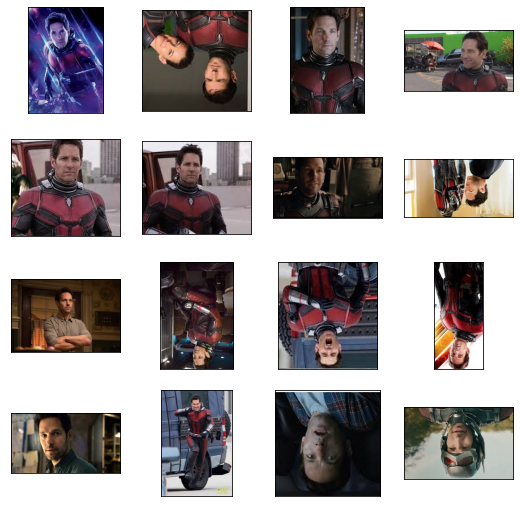

In [25]:
plt.figure(figsize=(9,9))
i = 0
for img in flip[0:16]:
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.show()